# Pairwise training
In this notebook, we demonstrate how to use pairwise model to predict in this competition. Please note that the inference time is much longer than pointwise method or using cosine similarity. 

1. I used a bert-small model pretrained with pairwise-mlm.
2. **Training with pairwise examples with negative samples randomly sampled.**
3. Inference and predict for all the pairs for test dataset.

* [Pretrain](https://www.kaggle.com/code/yuanzhezhou/ai4code-pairwise-bertsmall-pretrain/notebook)
* [Training](https://www.kaggle.com/yuanzhezhou/ai4code-pairwise-bertsmall-training)
* [Inference](https://www.kaggle.com/yuanzhezhou/ai4code-pairwise-bertsmall-inference)

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm
import os

os.environ["WANDB_DISABLED"] = "true"

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

BERT_PATH = "../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased"

data_dir = Path('../input/AI4Code')

In [2]:
NUM_TRAIN = 10000


def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )


paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)

df

Train NBs: 100%|██████████| 10000/10000 [01:20<00:00, 124.47it/s]


cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
000c0a9b2fef4d 1087237d      code  # Data manipulation\nimport pandas as pd\nimport numpy as np\n\n# Data visualization\nimport matplotlib.pyplot as pl...
               d7209f1f      code                                                                      fifa_raw_dataset = pd.read_csv('../input/data.csv')
               daf5b8ee      code                                                                                                  fifa_raw_dataset.head()
               e404213c      code                                                                                                  fifa_raw_dataset.info()
               2bad59b0      code                                                                                                   fifa_raw_dataset.shape
...                           ...                                                                                                                      ...
fffc63ff750064 56aa8da7      code                                                                 \nsubmission.to_csv('house_price_rf.csv', index = False)
               411b85d9  markdown                                                                                                    1. # Data exploration
               e7e67119  markdown                                                                                                   # # Data preprocessing
               8b54cf58  markdown                                                                                            # Post-process for submission
               b3c6bc16  markdown                                                                                                   # Define and fit model

[461166 rows x 2 columns]

In [3]:
# Get an example notebook
nb_id = df.index.unique('id')[6]
print('Notebook:', nb_id)

print("The disordered notebook:")
nb = df.loc[nb_id, :]
display(nb)
print()

Notebook: 00290ddf866418
The disordered notebook:


,cell_type,source
cell_id,,
4e6f32f6,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
0aeca210,code,"import warnings\nimport random\n\nSEED=44\nrandom.seed(SEED)\nnp.random.seed(SEED)\npd.set_option('display.width', N..."
cadfdb16,code,train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')\ntest = pd.read_csv('/kaggle/input...
fe39c117,code,train.info()
bbc5f229,code,"y = train.iloc[:,-1]\nX = train.iloc[:,:-1]\nZ = test"
46cc92d1,code,def get_obj_cols(df):\n return [col for col in df.columns if df.dtypes[col] == np.object]
9d6ea72b,code,X_objs = get_obj_cols(X)\nX_objs_idx = [X.columns.get_loc(col) for col in X_objs]\nZ_objs = get_obj_cols(Z)\nZ_objs_...
d0f88604,code,for obj in X_objs:\n X[obj] = X[obj].astype('category').cat.codes\nfor obj in Z_objs:\n Z[obj] = Z[obj].astype...
8df28832,code,"X.drop('id', axis=1, inplace=True)\nZ.drop('id', axis=1, inplace=True)"


In [4]:
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

df_orders

id
00001756c60be8    [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136...
00015c83e2717b    [2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c417225b, 51e3cd89, 2600b4eb, 75b65993, cf195f8b, 25699d02, 72b3201a, f2c75...
0001bdd4021779    [3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310c80, 073e27e5, 015d52a4, ad7679ef, 7fde4f04, 07c52510, 0a1a7a39, 0bcd3...
0001daf4c2c76d    [97266564, a898e555, 86605076, 76cc2642, ef279279, df6c939f, 2476da96, 00f87d0a, ae93e8e6, 58aadb1d, d20b0094, 986fd...
0002115f48f982                                 [9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe576, a3188e54, b3f6e12d, ee7655ca, 84125b7a]
                                                                           ...                                                           
fffc30d5a0bc46    [09727c0c, ff1ea6a0, ddfef603, a01ce9b3, 3ba953ee, bf92a015, f4a0492a, 095812e6, 53125cfe, aa32a700, 63340e73, 06d8c...
fffc3b44869198    [978a5137, fa

In [5]:
len(df_orders.loc["002ba502bdac45"])

73

In [6]:
cell_order = df_orders.loc[nb_id]

print("The ordered notebook:")
nb.loc[cell_order, :]

The ordered notebook:


,cell_type,source
cell_id,,
91d97bb2,markdown,# Read Data
4e6f32f6,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
0aeca210,code,"import warnings\nimport random\n\nSEED=44\nrandom.seed(SEED)\nnp.random.seed(SEED)\npd.set_option('display.width', N..."
cadfdb16,code,train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')\ntest = pd.read_csv('/kaggle/input...
fe39c117,code,train.info()
bbc5f229,code,"y = train.iloc[:,-1]\nX = train.iloc[:,:-1]\nZ = test"
91194a54,markdown,# Categorical
46cc92d1,code,def get_obj_cols(df):\n return [col for col in df.columns if df.dtypes[col] == np.object]
9d6ea72b,code,X_objs = get_obj_cols(X)\nX_objs_idx = [X.columns.get_loc(col) for col in X_objs]\nZ_objs = get_obj_cols(Z)\nZ_objs_...


In [7]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

cell_ranks = get_ranks(cell_order, list(nb.index))
nb.insert(0, 'rank', cell_ranks)

nb

,rank,cell_type,source
cell_id,,,
4e6f32f6,1,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
0aeca210,2,code,"import warnings\nimport random\n\nSEED=44\nrandom.seed(SEED)\nnp.random.seed(SEED)\npd.set_option('display.width', N..."
cadfdb16,3,code,train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')\ntest = pd.read_csv('/kaggle/input...
fe39c117,4,code,train.info()
bbc5f229,5,code,"y = train.iloc[:,-1]\nX = train.iloc[:,:-1]\nZ = test"
46cc92d1,7,code,def get_obj_cols(df):\n return [col for col in df.columns if df.dtypes[col] == np.object]
9d6ea72b,8,code,X_objs = get_obj_cols(X)\nX_objs_idx = [X.columns.get_loc(col) for col in X_objs]\nZ_objs = get_obj_cols(Z)\nZ_objs_...
d0f88604,9,code,for obj in X_objs:\n X[obj] = X[obj].astype('category').cat.codes\nfor obj in Z_objs:\n Z[obj] = Z[obj].astype...
8df28832,10,code,"X.drop('id', axis=1, inplace=True)\nZ.drop('id', axis=1, inplace=True)"


In [8]:
df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

df_ranks

rank
id             cell_id      
000c0a9b2fef4d 1087237d    2
               d7209f1f    4
               daf5b8ee    6
               e404213c    7
               2bad59b0    8
...                      ...
fffc63ff750064 56aa8da7   25
               411b85d9    1
               e7e67119    6
               8b54cf58   22
               b3c6bc16   18

[461166 rows x 1 columns]

In [9]:
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df_ancestors

,ancestor_id,parent_id
id,,
00001756c60be8,945aea18,NaN
00015c83e2717b,aa2da37e,317b65d12af9df
0001bdd4021779,a7711fde,NaN
0001daf4c2c76d,090152ca,NaN
0002115f48f982,272b483a,NaN
...,...,...
fffc30d5a0bc46,6aed207b,NaN
fffc3b44869198,a6aaa8d7,NaN
fffc63ff750064,0a1b5b65,NaN


In [10]:
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id
0,000c0a9b2fef4d,1087237d,code,# Data manipulation\nimport pandas as pd\nimport numpy as np\n\n# Data visualization\nimport matplotlib.pyplot as pl...,2,a2e47ece,NaN
1,000c0a9b2fef4d,d7209f1f,code,fifa_raw_dataset = pd.read_csv('../input/data.csv'),4,a2e47ece,NaN
2,000c0a9b2fef4d,daf5b8ee,code,fifa_raw_dataset.head(),6,a2e47ece,NaN
3,000c0a9b2fef4d,e404213c,code,fifa_raw_dataset.info(),7,a2e47ece,NaN
4,000c0a9b2fef4d,2bad59b0,code,fifa_raw_dataset.shape,8,a2e47ece,NaN
...,...,...,...,...,...,...,...
461161,fffc63ff750064,56aa8da7,code,"\nsubmission.to_csv('house_price_rf.csv', index = False)",25,0a1b5b65,NaN
461162,fffc63ff750064,411b85d9,markdown,1. # Data exploration,1,0a1b5b65,NaN
461163,fffc63ff750064,e7e67119,markdown,# # Data preprocessing,6,0a1b5b65,NaN
461164,fffc63ff750064,8b54cf58,markdown,# Post-process for submission,22,0a1b5b65,NaN


<AxesSubplot:>

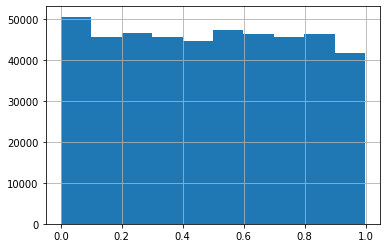

In [11]:
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

df["pct_rank"].hist(bins=10)

In [12]:
dict_cellid_source = dict(zip(df['cell_id'].values, df['source'].values))

In [13]:
import numpy as np
import pandas as pd
import os
import re
# import fasttext
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from pathlib import Path
import nltk
nltk.download('wordnet')

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        #return document

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

    
def preprocess_df(df):
    """
    This function is for processing sorce of notebook
    returns preprocessed dataframe
    """
    return [preprocess_text(message) for message in df.source]

df.source = df.source.apply(preprocess_text)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
from tqdm import tqdm
import sys, os
try:
  from transformers import DistilBertModel, DistilBertTokenizer
except:
  !pip install transformers
  from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

from transformers import BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

# if not os.path.exists('text.txt'):
#   with open('text.txt','w') as f:
#     for id, item in tqdm(df.groupby('id')):
#       df_markdown =  item[item['cell_type']=='markdown']
#       for source, rank in df_markdown[['source', 'rank']].values:
#         cell_source = df_markdown[df_markdown['rank']==(rank+1)]
#         if len(cell_source):
#           setence = source + ' [SEP] ' + cell_source.source.values[0]
#           f.write(setence+'\n')
      

# # Train a tokenizer
# import tokenizers
# from transformers import BertTokenizer, LineByLineTextDataset

# tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-small')

In [15]:
# model = AutoModelWithLMHead.from_pretrained('prajjwal1/bert-small')


# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tokenizer, mlm=True, mlm_probability=0.15
# )

# from transformers import Trainer, TrainingArguments

# dataset= LineByLineTextDataset(
#     tokenizer = tokenizer,
#     file_path = './text.txt',
#     block_size = 128  # maximum sequence length
# )

# print('No. of lines: ', len(dataset)) # No of lines in your datset

# training_args = TrainingArguments(
#     output_dir='./',
#     overwrite_output_dir=True,
#     num_train_epochs=10,
#     per_device_train_batch_size=64,
#     save_steps=10000,
# )
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     data_collator=data_collator,
#     train_dataset=dataset,
# )
# trainer.train()
# trainer.save_model('./')

# 위까지 Pretrain

In [16]:
def generate_triplet(df, mode='train'):
  triplets = []
  ids = df.id.unique()
  random_drop = np.random.random(size=10000)>0.9
  count = 0

  for id, df_tmp in tqdm(df.groupby('id')):
    df_tmp_markdown = df_tmp[df_tmp['cell_type']=='markdown']

    df_tmp_code = df_tmp[df_tmp['cell_type']=='code']
    df_tmp_code_rank = df_tmp_code['rank'].values
    df_tmp_code_cell_id = df_tmp_code['cell_id'].values

    for cell_id, rank in df_tmp_markdown[['cell_id', 'rank']].values:
      labels = np.array([(r==(rank+1)) for r in df_tmp_code_rank]).astype('int')

      for cid, label in zip(df_tmp_code_cell_id, labels):
        count += 1
        if label==1:
          triplets.append( [cell_id, cid, label] )
          # triplets.append( [cid, cell_id, label] )
        elif mode == 'test':
          triplets.append( [cell_id, cid, label] )
          # triplets.append( [cid, cell_id, label] )
        elif random_drop[count%10000]:
          triplets.append( [cell_id, cid, label] )
          # triplets.append( [cid, cell_id, label] )
    
  return triplets

triplets = generate_triplet(df)

100%|██████████| 10000/10000 [00:24<00:00, 413.06it/s]


In [17]:
from bisect import bisect


def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

In [18]:
from tqdm import tqdm
import sys, os
try:
  from transformers import DistilBertModel, DistilBertTokenizer
except:
  !pip install transformers
  !pip install sentencepiece
  from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel


import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from transformers import AlbertTokenizer, AlbertModel


MAX_LEN = 128
    
class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        self.distill_bert = AutoModel.from_pretrained("../input/mymodelbertsmallpretrained/checkpoint-120000")
        self.top = nn.Linear(512, 1)

        self.dropout = nn.Dropout(0.2)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = self.dropout(x)
        x = self.top(x[:, 0, :])
        x = torch.sigmoid(x) 
        return x

In [19]:
from torch.utils.data import DataLoader, Dataset



class MarkdownDataset(Dataset):
    
    def __init__(self, df, max_len, mode='train'):
        super().__init__()
        self.df = df
        self.max_len = max_len
        self.tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small", do_lower_case=True)
        self.mode=mode

    def __getitem__(self, index):
        row = self.df[index]

        label = row[-1]

        txt = dict_cellid_source[row[0]] + '[SEP]' + dict_cellid_source[row[1]]

        inputs = self.tokenizer.encode_plus(
            txt,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([label])




    def __len__(self):
        return len(self.df)


train_ds = MarkdownDataset(triplets, max_len=MAX_LEN, mode='test')

train_ds[1]

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

(tensor([  101,  1001,  2986,  1011,  8694,  1996,  2944,   102,  5713,  1035,
          2951, 13462,  1012,  4338,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [20]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 5e-5
    elif epoch < 5:
        lr = 5e-5
    else:
        lr = 5e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-8 ) #1e-08)
    return optimizer

BS = 128 + 128
NW = 8

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()

def validate(model, val_loader, mode='train'):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            pred = model(inputs[0], inputs[1])

            preds.append(pred.detach().cpu().numpy().ravel())
            if mode=='test':
              labels.append(target.detach().cpu().numpy().ravel())
    if mode=='test':
      return np.concatenate(preds)
    else:
      return np.concatenate(labels), np.concatenate(preds)

def train(model, train_loader, epochs, Type='markdown'):
    np.random.seed(0)
    
    optimizer = get_optimizer(model)

    mixed_precision = True
    try:  
        from apex import amp
    except:
        mixed_precision = False  # not installed

    # model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=1)
    

    criterion = torch.nn.L1Loss()
    criterion = torch.nn.BCELoss()
    
    for e in range(epochs):   
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        lr = adjust_lr(optimizer, e)
        
        loss_list = []
        preds = []
        labels = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            optimizer.zero_grad()
            pred = model(inputs[0], inputs[1])

            loss = criterion(pred, target)

            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.detach().cpu().item())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            
            avg_loss = np.round(np.mean(loss_list), 4)

            tbar.set_description(f"Epoch {e+1} Loss: {avg_loss} lr: {lr}")

        
        output_model_file = f"./my_own_model_{e}.bin"
        model_to_save = model.module if hasattr(model, 'module') else model
        torch.save(model_to_save.state_dict(), output_model_file)





    return model

model = MarkdownModel()
model = model.cuda()


model = train(model, train_loader, epochs=1, Type='markdown')


Some weights of the model checkpoint at ../input/mymodelbertsmallpretrained/checkpoint-120000 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../input/mymodelbertsmallpretrained/checkpoint-120000 and are newly ini

  0%|          | 0/3472 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

In [22]:
!zip -r model.zip ../input/mymodelbertsmallpretrained/checkpoint-120000

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: ../input/mymodelbertsmallpretrained/checkpoint-120000/ (stored 0%)
  adding: ../input/mymodelbertsmallpretrained/checkpoint-120000/config.json (deflated 47%)
  adding: ../input/mymodelbertsmallpretrained/checkpoint-120000/trainer_state.json (deflated 83%)
  adding: ../input/mymodelbertsmallpretrained/checkpoint-120000/training_args.bin (deflated 48%)
  adding: ../input/mymodelbertsmallpretrained/checkpoint-120000/pytorch_model.bin (deflated 7%)
  adding: ../input/mymodelbertsmallpretrained/checkpoint-120000/scheduler.pt (deflated 48%)
  adding: ../input/mymodelbertsmallpretrained/checkpoint-120000/optimizer.pt (deflated 8%)
  adding: ../input/mymodelbertsmal

In [23]:
import numpy as np
from IPython.display import FileLink
import os

# result = np.array([0.0])
# np.save("/kaggle/working/embedding",result)
os.chdir(r'/kaggle/working')
FileLink(r'model.zip')

/kaggle/working/model.zip

# Please upvote if you find it helpful! :D